# Normal scale mixture tests

In [1]:
%load_ext autoreload
%autoreload 2

In [62]:
from como.component_distributions import NormalScaleMixtureComponent, lossNSM, gradNSM, hessNSM, newtonNSM
from como.component_distributions import _nsm_convolved_logpdf, eta2pi, pi2eta
import numpy as np
import jax.numpy as jnp
from jax import jit
import jax
import matplotlib.pyplot as plt

n = 100000
scales = np.array([1.0, 2.0, 4.0, 8.0, 16.0, 32.0])
eta = np.random.normal(size = scales.size-1)
pi = np.array(eta2pi(eta))

z = np.random.choice(6, replace=True, size=n, p=pi/pi.sum())
beta = np.random.normal(size=n) * scales[z]
se = np.ones(n)
beta_hat = beta + np.random.normal(size=n) * se

In [63]:
import jax.scipy as jsp
from jax import vmap

def mixpdf(beta, se, scales, pi):
    sigmas = jnp.sqrt(se**2 + scales**2)
    return jsp.stats.norm.pdf(beta, loc=0., scale=sigmas) @ pi

mixpdf_vec = vmap(mixpdf, (0, 0, None, None), 0)

L2 = lambda eta: jnp.sum(jnp.log(mixpdf_vec(beta_hat, se, scales, eta2pi(eta))))
L2(eta)

DeviceArray(-364190.9, dtype=float32)

In [64]:
def mix_assignment_prop(beta, se, loc, scales, eta):
    sigmas = jnp.sqrt(se**2 + scales**2)
    # eta0 = jnp.concatenate([eta, jnp.array([0.])])
    logpi = jnp.log(eta2pi(eta))
    loglik = jsp.stats.norm.logpdf(beta, loc, scale=sigmas)
    return jax.nn.softmax(loglik + logpi)

mix_assigment_prop_vec = vmap(
    mix_assignment_prop,
    (0, 0, None, None, None), 0
)

@jit
def emNSM(beta, se, loc, scales, eta):
    R = mix_assigment_prop_vec(beta, se, loc, scales, eta)
    Rsum = R.sum(0)
    pi_new = Rsum / Rsum.sum()
    return pi2eta(pi_new)

In [65]:
np.set_printoptions(precision=2)

L = lambda eta: lossNSM(beta_hat, se, 0., scales, eta)
print(
    f'true loss: {L(eta):.3f}',
    f'true pi: {eta2pi(eta)}'
)

true loss: -364190.875 true pi: [0.1  0.38 0.02 0.2  0.11 0.19]


In [66]:
eta_init = np.zeros(scales.size-1)
print(
    f'init loss: {L(eta_init):.3f}',
    f'init pi: {eta2pi(eta_init)}'
)

init loss: -364668.625 init pi: [0.17 0.17 0.17 0.17 0.17 0.17]


In [67]:
eta_est = eta_init
losses = [L(eta_est)]
for _ in range(100):
    eta_est = emNSM(beta_hat, se, 0., scales, eta_est)
    losses.append(L(eta_est))
    print(
        f'loss: {losses[-1]:.3f}',
        f'pi: {eta2pi(eta_est)}'
    )

loss: -364483.812 pi: [0.18 0.18 0.17 0.16 0.16 0.16]
loss: -364411.500 pi: [0.18 0.18 0.16 0.15 0.15 0.17]
loss: -364373.750 pi: [0.19 0.19 0.16 0.15 0.15 0.17]
loss: -364351.125 pi: [0.19 0.19 0.16 0.14 0.15 0.17]
loss: -364336.750 pi: [0.19 0.19 0.16 0.14 0.14 0.17]
loss: -364327.281 pi: [0.19 0.19 0.16 0.14 0.14 0.18]
loss: -364320.812 pi: [0.19 0.19 0.16 0.14 0.14 0.18]
loss: -364316.125 pi: [0.19 0.2  0.16 0.14 0.14 0.18]
loss: -364312.656 pi: [0.19 0.2  0.15 0.14 0.14 0.18]
loss: -364309.875 pi: [0.19 0.2  0.15 0.14 0.14 0.18]
loss: -364307.562 pi: [0.19 0.2  0.15 0.14 0.14 0.18]
loss: -364305.562 pi: [0.19 0.2  0.15 0.14 0.14 0.18]
loss: -364303.750 pi: [0.19 0.2  0.15 0.13 0.14 0.18]
loss: -364302.125 pi: [0.19 0.21 0.15 0.13 0.14 0.18]
loss: -364300.594 pi: [0.19 0.21 0.15 0.13 0.14 0.18]
loss: -364299.062 pi: [0.19 0.21 0.15 0.13 0.14 0.18]
loss: -364297.625 pi: [0.19 0.21 0.15 0.13 0.14 0.18]
loss: -364296.250 pi: [0.19 0.21 0.15 0.13 0.14 0.18]
loss: -364294.938 pi: [0.19 

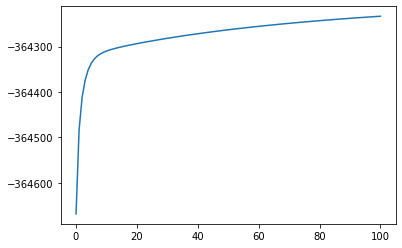

In [68]:
plt.plot(losses)

In [69]:
from como.component_distributions import NormalScaleMixtureComponent

f = NormalScaleMixtureComponent(
    0.0, scales, np.ones(scales.size) / scales.size)

losses = [f.convolved_logpdf(beta_hat, se).sum()]
for _ in range(20):
    f.update(dict(beta=beta_hat, se=se, y=0))
    losses.append(f.convolved_logpdf(beta_hat, se).sum())

In [70]:
data = dict(beta=beta_hat, se=se, y=1.)

In [71]:
%%time
f = NormalScaleMixtureComponent(
    0.0, scales, np.ones(scales.size) / scales.size)
f.update(data, niter=2)
f.convolved_logpdf(beta_hat, se).sum()

CPU times: user 307 ms, sys: 17.7 ms, total: 324 ms
Wall time: 370 ms


DeviceArray(-364411.5, dtype=float32)

In [78]:
f = NormalScaleMixtureComponent(
    0.0, scales, np.ones(scales.size) / scales.size)
%timeit f.update(data, niter=20)
f.convolved_logpdf(beta_hat, se).sum()

272 ms ± 12.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


DeviceArray(-364214.44, dtype=float32)

In [80]:
f = NormalScaleMixtureComponent(
    0.0, scales, np.ones(scales.size) / scales.size)
%timeit f.update(data, niter=200)
f.convolved_logpdf(beta_hat, se).sum()

654 ms ± 10.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


DeviceArray(-364187.7, dtype=float32)

In [77]:
%%time
f = NormalScaleMixtureComponent(
    0.0, scales, np.ones(scales.size) / scales.size)
f.update(data, niter=2000)
f.convolved_logpdf(beta_hat, se).sum()

CPU times: user 5.52 s, sys: 157 ms, total: 5.68 s
Wall time: 4.58 s


DeviceArray(-364187.6, dtype=float32)